# Анализ республиканской инфляции (2011 - 2024)

In [1]:
#Импорты и чтение данных
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np 

import math
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import networkx as nx

#Vizualizations
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

df = pd.read_pickle('RepublicInflation062024.pkl')
pivot_data = df.pivot(index='date_dt', columns='label', values='value') #Создадим пивот таблицу

Источник данных: <a href = "https://taldau.stat.gov.kz/ru/NewIndex/GetIndex/703076">Индекс потребительских цен БНС</a><br>
Период: Месяц <br>
Соотнесение периодов: отчетный период к предыдущему периоду <br>
Количество категорий потребительских товаров: 168 <br>
Период: Январь 2011 - Май 2024<br>

Подогтовка данных:
1. Категории потребительских товаров разложены по иеррахии в Талдау
2. Найден самый нижний уровень в каждой ветке
3. "Дырявые" временные ряды заменены более высоким рядом по иерархии, а ряды, которые находились на одном уровн, удалены, чтобы исключить double counting

Для понимания каждого временного ряда, найдем его максимальную корреляцию с другими категориями потребительских товаров.

In [2]:
#Вычисление максимальной корреляции
result = pivot_data.corr()
result_no_diag = result.copy()
np.fill_diagonal(result_no_diag.values, np.nan)

max_corr_each_row = result_no_diag.max(axis=1)
max_corr_col_each_row = result_no_diag.idxmax(axis=1)

max_corr_info = pd.DataFrame({
    'Максимальная корреляция': max_corr_each_row,
    'Колонка для сравнения': max_corr_col_each_row
})
max_corr_info.index.name = "Категории инфляции"

max_corr_info.sort_values(by = 'Максимальная корреляция', ascending = False)

,Максимальная корреляция,Колонка для сравнения
Категории инфляции,,
"Женская одежда, кроме трикотажных и чулочно-носочных изделий_5259121",0.984987,"Мужская одежда, кроме трикотажных и чулочно-но..."
"Мужская одежда, кроме трикотажных и чулочно-носочных изделий_5259093",0.984987,"Женская одежда, кроме трикотажных и чулочно-но..."
Мужские трикотажные изделия и носки_5259109,0.982522,"Мужская одежда, кроме трикотажных и чулочно-но..."
Женская обувь_5259240,0.980741,Мужская обувь_5259229
Мужская обувь_5259229,0.980741,Женская обувь_5259240
...,...,...
Газ_5259349,0.274726,"Водоснабжение и другие услуги, связанные с сод..."
Проезд в междугороднем автобусе_5259726,0.263912,Мотоциклы_5259649
Проезд городским автобусом_5259717,0.246709,Газ_5259349


Категории с низкой максимальной корреляцией скорее всего не имеют связей с другими категориями. <br>
Распределение максимальной корреляции ниже. <br>

In [3]:
#Описательный анализ максимальной корреляции 
max_corr_info.sort_values(by = 'Максимальная корреляция', ascending = False).describe() 

,Максимальная корреляция
count,168.000000
mean,0.721388
std,0.193238
min,0.109030
25%,0.581462
50%,0.754755
75%,0.867710
max,0.984987


## CMGR - Тренды инфляции (последние 120 месяцев)

In [4]:
#Вычисление cmgr
cmgr = pivot_data + 100
def calculate_relative_inflation(series):
    last_120_values = series.tail(120)  
    n = len(last_120_values) 
    if n == 0:
        return np.nan  
    product = last_120_values.prod()
    if product <= 0:
        return np.nan  
    relative_inflation = (product / (100 ** n)) ** (1 / n) - 1
    return relative_inflation

relative_inflation = cmgr.apply(calculate_relative_inflation, axis=0)

Топ 10 самого низкого CMGR:

In [5]:
relative_inflation.index.name = "Категории инфляции"
relative_inflation.sort_values().head(10)*100 

Категории инфляции
Телефонное и факсимильное оборудование_4771744                         0.119929
Услуги телефонной и факсимильной связи_4771753                         0.219241
Почтовые услуги_5259888                                                0.238137
Прочие финансовые услуги, не отнесенные к другим категориям_4772099    0.262437
Картофель_4770906                                                      0.267755
Газ_5259349                                                            0.304564
Овощи свежие_4770884                                                   0.382300
Проезд городским автобусом_5259717                                     0.406389
Проживание в гостинице_4772003                                         0.444082
Дошкольное и начальное образование_4771953                             0.458816
dtype: float64

Топ 10 самого высокого CMGR:

In [6]:
relative_inflation.sort_values(ascending = False).head(10)*100 #CMGR отсортирован

Категории инфляции
Мыло хозяйственное_5259528                                         1.275061
Масло оливковое_4770834                                            1.228911
Фрукты консервированные_4770870                                    1.223281
Велосипед детский_5259660                                          1.187467
Детская обувь_5259253                                              1.175292
Сигареты_5258551                                                   1.141983
Молоко консервированное_4770788                                    1.114909
Полуфабрикаты для изготовления напитков на основе какао_4771009    1.114567
Напитки газированные_4771018                                       1.081313
Чай зеленый_4771003                                                1.073800
dtype: float64

## Сезональность

Для поиска товаров с высокой сезональностью можно создать сдвинутые на 12 месяцев временные ряды и найти корреляцию с ними.

In [7]:
#Вычисления сезональности
lagged_df = pivot_data.shift(12)

corr_table_seasonality = pd.DataFrame(columns=['Категории инфляции', 'Сдвинутый ряд', 'Корреляция'])

for col in pivot_data.columns:
    corr_value = pivot_data[col].corr(lagged_df[col])
    new_row = pd.DataFrame({
        'Категории инфляции': [col],
        'Сдвинутый ряд': [f'{col}_сдвинутый'],
        'Корреляция': [corr_value]
    })
    corr_table_seasonality = pd.concat([corr_table_seasonality, new_row], ignore_index=True)
filtered_corr_table = corr_table_seasonality[corr_table_seasonality['Корреляция'] > 0.5].sort_values(by = 'Корреляция', ascending = False)
filtered_corr_table

,Категории инфляции,Сдвинутый ряд,Корреляция
12,Высшее образование_4771973,Высшее образование_4771973_сдвинутый,0.836489
96,Профессиональное среднее образование_4771971,Профессиональное среднее образование_4771971_с...,0.817611
121,Среднее образование_4771961,Среднее образование_4771961_сдвинутый,0.805569
76,Овощи свежие_4770884,Овощи свежие_4770884_сдвинутый,0.711112
141,Услуги санаториев_5259637,Услуги санаториев_5259637_сдвинутый,0.599273
128,Страхование_4772078,Страхование_4772078_сдвинутый,0.593476
167,Яйца_4770813,Яйца_4770813_сдвинутый,0.573383
21,Дрова_5259366,Дрова_5259366_сдвинутый,0.540532
11,Воздушный пассажирский транспорт_5259728,Воздушный пассажирский транспорт_5259728_сдвин...,0.535138


In [8]:
#Визуализация
filtered_vars = filtered_corr_table['Категории инфляции'].tolist()

seasonality = dash.Dash(__name__)

seasonality.layout = html.Div([
    dcc.Dropdown(
        id='variable-dropdown',
        options=[{'label': var, 'value': var} for var in filtered_vars],
        value=filtered_vars[0]
    ),
    dcc.Graph(id='time-series-graph'),
    html.Div("*Для того чтобы приблизить, зажмите и протяните мышкой, выбирая нужную область",
             style={'margin-top': '20px', 'font-family': 'Gotham', 'font-size': '14px', 'color': '#000000'})
])

@seasonality.callback(
    Output('time-series-graph', 'figure'),
    [Input('variable-dropdown', 'value')]
)
def update_graph(selected_var):
    corr_value = filtered_corr_table.loc[filtered_corr_table['Категории инфляции'] == selected_var, 'Корреляция'].values[0]
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=pivot_data.index, y=pivot_data[selected_var], mode='lines', name=selected_var, line=dict(color='#376c8a')))
    
    fig.add_trace(go.Scatter(x=lagged_df.index, y=lagged_df[selected_var], mode='lines', name=f'{selected_var}_сдвинутый', line=dict(color='#e5b983')))
    
    fig.update_layout(
        title=f'Сравнение временных рядов и их сдвигов:<br>{selected_var} (Корреляция: {corr_value:.2f})',
        yaxis_title='Инфляция',
        legend_title='Категория',
        font=dict(family='Gotham', size=14),
        plot_bgcolor='white',
        paper_bgcolor='white',
        xaxis=dict(
            showgrid=True,
            gridcolor='lightgrey'
        ),
        yaxis=dict(
            showgrid=True,
            gridcolor='lightgrey'
        ),
        margin=dict(l=20, r=20, t=100, b=20)
    )
    
    return fig

if __name__ == '__main__':
    seasonality.run_server(port=8050, debug=True)

## Кластеризация

### Мотивация

Инфляция - это агрегированная переменная, поэтому полезно разложить инфляцию на основные группы (кластеры), которые на нее влияют. 

### Масштабирование

In [9]:
#Описательный анализ переменной
pivot_data_clustering = df.pivot(index='date_dt', columns='label', values='value')
X = TimeSeriesScalerMeanVariance().fit_transform(pivot_data_clustering.T) #Scaling для сглаживания данных
cluster_count = math.ceil(math.sqrt(len(X)))
df[['value']].describe()

,value
count,27048.000000
mean,0.720819
std,1.756635
min,-20.400000
25%,0.100000
50%,0.400000
75%,0.900000
max,40.700000


TimeSeriesScalerMeanVariance Скалер для временных рядов. Масштабирует временные ряды так, чтобы их среднее значение (соответственно стандартное отклонение) в каждом измерении составляло 0 и 1

In [10]:
#Вычисления для анализа
mean_ = np.mean(X)
median_ = np.median(X)
min_ = np.amin(X)
max_ = np.amax(X)
range_ = np.ptp(X)
variance_ = np.var(X)
sd_ = np.std(X)
print("Описательный анализ масштабированной переменной")
print("Среднее =", int(mean_))
print("Медиана =", median_)
print("Минимум =", min_)
print("Максимум =", max_)
print("Диапазон =", range_)
print("Стандартное отклонение =", sd_)

Описательный анализ масштабированной переменной
Среднее = 0
Медиана = -0.2211312851044351
Минимум = -7.370311055888087
Максимум = 11.519637685005188
Диапазон = 18.889948740893274
Стандартное отклонение = 1.0


### Определение числа кластеров

Число кластеров для начала определяется через квадрат от числа временных рядов = 13 <br><br>
TimeSeriesKMeans - это метод кластеризации временных рядов, который расширяет классический алгоритм KMeans, чтобы работать с временными рядами. Основное отличие заключается в метрике расстояния, которая используется для вычисления расстояния между временными рядами.
<br>
Euclidean cравнивает ряды один к одному, без учета временных искажений. <br>
Инерция - это сумма расстояний рядов до ближайшего центра кластера. <br><br>
Ниже можно увидеть Elbow Method, нам нужно визуально определить место сгиба, где есть самое большое падение в сумме расстояний. <br> 
Оптимальное количества кластеров = 8 

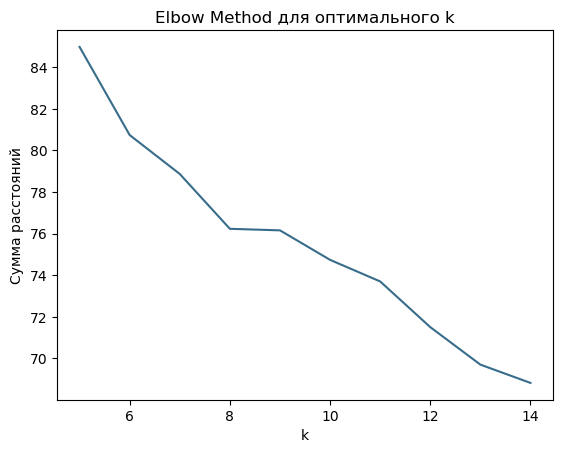

In [11]:
#Вычиление для определение числа кластеров
Sum_of_distances_euclidean = []
K = range(5,15)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k, metric="euclidean", verbose=False, random_state=42)
    km = km.fit(X)
    Sum_of_distances_euclidean.append(km.inertia_)
plt.plot(K, Sum_of_distances_euclidean, color='#376c8a')
plt.xlabel('k')
plt.ylabel('Сумма расстояний')
plt.title('Elbow Method для оптимального k')
plt.show()

### Финальный кластеринг

In [12]:
#Вычисление и визуализация
kmE = TimeSeriesKMeans(n_clusters=8,
                        metric="euclidean",
                        verbose=False,
                        random_state=42)

kmE = kmE.fit(X)

ClusteredData = pivot_data_clustering.T
ClusteredData['cluster'] = kmE.labels_
clusters = ClusteredData['cluster'].unique()
data_dict = {}

cluster_names = {
    0: "Здравоохранение, проезд и другое",
    1: "Товары длительного пользования (одежда)",
    2: "Продовольствия для ежедневного пользования",
    3: "Продовольствия длительного хранения",
    4: "Коммунальные услуги",
    5: "Мясо",
    6: "Бытовые приборы и другое",
    7: "Образование и другое"
}

for cluster in clusters:
    cluster_data = ClusteredData[ClusteredData['cluster'] == cluster]
    cluster_timeseries = cluster_data.drop(columns=['cluster']).values
    cluster_avg = np.mean(cluster_timeseries, axis=0)
    date_columns = cluster_data.drop(columns=['cluster']).columns
    data_dict[cluster] = {
        'timeseries': cluster_timeseries,
        'average': cluster_avg,
        'index_names': cluster_data.index,
        'date_columns': date_columns
    }

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Tabs(id="tabs", value='tab-1', children=[
        dcc.Tab(label=f'Cluster {cluster}', value=f'tab-{cluster}') for cluster in clusters
    ]),
    html.Div(id='tabs-content'),

    
    html.Div("*Для того чтобы приблизить, зажмите и протяните мышкой, выбирая нужную область",
             style={'margin-top': '20px', 'font-family': 'Gotham', 'font-size': '14px', 'color': '#000000'})

])

@app.callback(Output('tabs-content', 'children'),
              [Input('tabs', 'value')])
def render_content(tab):
    cluster = int(tab.split('-')[1])
    cluster_data = data_dict[cluster]
    timeseries = cluster_data['timeseries']
    average = cluster_data['average']
    index_names = cluster_data['index_names']
    date_columns = cluster_data['date_columns']

    traces = []
    for i, ts in enumerate(timeseries):
        traces.append(go.Scatter(
            x=date_columns,
            y=ts,
            mode='lines',
            line=dict(width=1, color='#e5b983'),
            name=index_names[i]
        ))

    traces.append(go.Scatter(
        x=date_columns,
        y=average,
        mode='lines',
        line=dict(width=2.5, color='#376c8a'),
        name='Среднее'
    ))

    return dcc.Graph(
        figure={
            'data': traces,
            'layout': go.Layout(
                title=cluster_names[cluster],
                showlegend=True,
                font=dict(family='Gotham', size=14),
        plot_bgcolor='white',
        paper_bgcolor='white',
        xaxis=dict(
            showgrid=True,
            gridcolor='lightgrey'
        ),
        yaxis=dict(
            showgrid=True,
            gridcolor='lightgrey'
        ),
        margin=dict(l=20, r=20, t=100, b=20)
    )
        }
    )

if __name__ == '__main__':
    app.run_server(port=8051, debug=True)